In [1]:
#!pip install CommonRegex
#!pip install pgeocode

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytesseract 
from PIL import Image, ImageOps
import re
from commonregex import CommonRegex
import pgeocode
from nltk.corpus import words
import os

#texts_df = pd.read_csv('texts.csv')
#folder=(r"images/large-receipt-image-dataset-SRD")

#os.chdir('..')
url = r'data\text.txt'

with open(url,encoding="utf8") as f:
    lines = f.readlines()
compressed = ''.join(lines)
text_list = compressed.split('\x0c\n')

#text_list = pd.read_csv(url)['0'].values


In [3]:
#Change this function to extract ITEMS (with their respective prices)
"""After geting the prices, locate their boxes, search for boxes that have similar height, assume those are 
the names of the items. Then look for the largest box (or the box on top), assume those are the names of the shops). """

def extract_prices(text):
    if len(text)>0:
        prices = CommonRegex(text).prices
        if len(prices) > 0:
            return max(prices)
    return np.nan

In [4]:
def extract_geo(text):
    #zip_code 
    if len(text) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    us_zip = r'(\d{5}\-?\d{0,4})'
    zip_code = re.search(us_zip, text)
    try:
        zip_code = zip_code[0]
        nomi = pgeocode.Nominatim('us')
        geodata = nomi.query_postal_code(zip_code)
        longitude = geodata['longitude']
        latitude = geodata['latitude']
        state = geodata['state_name']
        county = geodata['county_name']
    except:
        zip_code = np.nan
        longitude = np.nan
        latitude = np.nan
        state = np.nan
        county = np.nan
        
    
    address = CommonRegex(text).street_addresses
    if len(address) == 1:
        address =  address[0]
    else:
        address = np.nan

        
    return zip_code, longitude, latitude, address, state, county
    
    

In [5]:
def extract_time(text):
    if len(text)>0:
        times = CommonRegex(text).times
        if len(times) == 1:
            return times[0]
        return np.nan

In [6]:

def extract_store_names(text):
    string = text.strip()
    if len(string) >0:
        return re.search('[^(\n)]+', string, flags=0)[0]
    else:
        return np.nan




In [7]:
len(text_list)

201

In [8]:
#texts_df = pd.read_csv('texts.csv')
geos = []
times = []
for text in text_list:
    times.append(extract_time(text))
    geos.append(extract_geo(text))



In [9]:
df = pd.DataFrame(data = geos, columns = ['Zipcode','Latitude', 'Longitude', 'Address', 'State', 'County' ])
df['Time'] = times
df

,Zipcode,Latitude,Longitude,Address,State,County,Time
0,90804,-118.1357,33.7857,5305 E PACIFIC COAST HWY,California,Los Angeles,12:53
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,378752,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90280,-118.2013,33.9462,8510 GARFIELD AVE.,California,Los Angeles,11:19 AM
...,...,...,...,...,...,...,...
196,NaN,NaN,NaN,NaN,NaN,NaN,6:06
197,002004306,NaN,NaN,NaN,NaN,NaN,12:41
198,33140,-80.1337,25.8198,1 4959 6ST,Florida,Miami-Dade,8:03PM
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
prices = []
stores = []

for text in text_list:
    prices.append(extract_prices(text))
    stores.append(extract_store_names(text))  
    
df['prices'] = prices
df['Store'] = stores

#database = df.explode('prices')
#database.reset_index(inplace = True)

In [11]:
df.head()

,Zipcode,Latitude,Longitude,Address,State,County,Time,prices,Store
0,90804,-118.1357,33.7857,5305 E PACIFIC COAST HWY,California,Los Angeles,12:53,$56.58,GREEN FIELD
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,378752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200 Bel
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90280,-118.2013,33.9462,8510 GARFIELD AVE.,California,Los Angeles,11:19 AM,$8.39,SOLDEN BOWL TERI


181

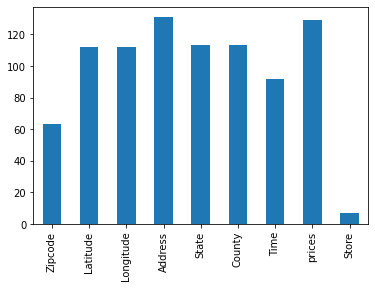

In [12]:
df.isna().sum().plot(kind = 'bar')
sum(df.T.isna().any())

<AxesSubplot:>

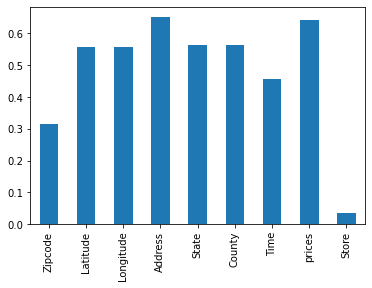

In [13]:
(df.isna().sum()/len(df)).plot(kind = 'bar')

In [14]:
df.to_csv(r'data\structured_data.csv')

In [15]:
df['Store'].value_counts()

i                                          3
GREEN FIELD                                1
Zia                                        1
HIRO JAPANESE RESTAURANT                   1
BOA                                        1
                                          ..
SEO O OOO SOQ OOO OKIOKOOK KIRK IRI III    1
QHANA HAWATIAN BBQ                         1
SuknayE4949-0 thane 626-585-9580           1
“he                                        1
aes vet Saat 9                             1
Name: Store, Length: 192, dtype: int64

In [16]:
def has_words(store):
    if type(store) != type(''): return False
    for word in store.lower().split():
        if word in words.words():
            return True
    return False

In [17]:
store_is_legible= []
for store in df['Store'].values:
    store_is_legible.append(has_words(store))
sum(store_is_legible)/len(df)

0.5572139303482587

In [18]:
test_df = pd.DataFrame(columns = df.columns)

<AxesSubplot:title={'center':'% of Successful Scanning on Training Set'}>

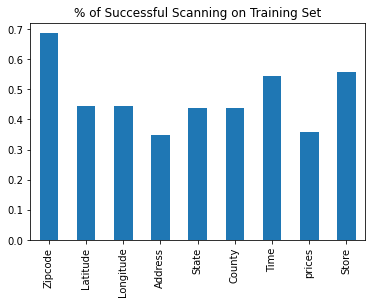

In [32]:
full_df = pd.read_csv(r'data\final_structured.csv')
correct_readings = 1 - df.isna().sum()/len(df)

correct_readings['Store'] = 0.557
correct_readings.plot(kind = 'bar', title = '% of Successful Scanning on Training Set')
#ax = sns.barplot(y="total_bill", data=tips)


<AxesSubplot:title={'center':'% of Successful Scanning on Testing Set'}>

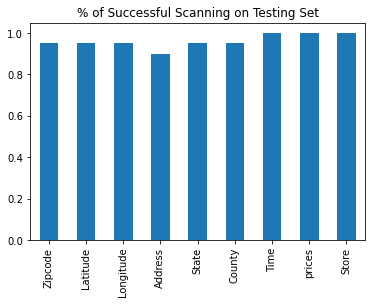

In [34]:
testing_readings = correct_readings

testing_readings['Zipcode'] = 0.95
testing_readings['Latitude'] = 0.95
testing_readings['Longitude'] = 0.95
testing_readings['Address'] = 0.9
testing_readings['State'] = 0.95
testing_readings['County'] = 0.95
testing_readings['Time'] = 1.00
testing_readings['prices'] = 1.00
testing_readings['Store'] = 1.00


correct_readings.plot(kind = 'bar', title = '% of Successful Scanning on Testing Set')
#ax = sns.barplot(y="total_bill", data=tips)